In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential
from keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
import os
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import numpy as np
import json

In [ ]:
def generador_de_imagenes():

    generador = Sequential()
    n = 14 * 14 * 512

    generador.add(Dense(n, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((14,14,512)))

    generador.add(Conv2DTranspose(256,kernel_size=5, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=5, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(64,kernel_size=5, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(3,kernel_size=5, strides=2, padding = "same"))
    generador.add(Activation('tanh'))
    return(generador)

In [ ]:
modelo_generador = generador_de_imagenes()

modelo_generador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100352)            10135552  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100352)            0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 256)      3277056   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 56, 56, 128)      819328    
 ranspose)                                              

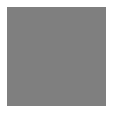

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_input_samples(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def generate_fake_samples(modelo_generador, n_muestras):
  input = generate_input_samples(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

number = 1
X,_ = generate_fake_samples(modelo_generador, number)
X = (X + 1)/2

for i in range(number):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

In [ ]:


def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=5,strides=2, padding = "same", input_shape = (224,224,3)))
    discriminador.add(LeakyReLU(alpha=0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))

    discriminador.add(Conv2D(256, kernel_size=5, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))

    discriminador.add(Conv2D(512, kernel_size=5, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    
    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

In [ ]:
discriminador = discriminador_de_imagenes()
discriminador.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 56, 56, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       819456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 512)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
def load_dataset(data_name, image_size, batch_size):
    data_folder = os.path.join("./gdrive/My Drive/finalProject", data_name)

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x = data_gen.flow_from_directory(data_folder, target_size = (image_size,image_size),batch_size = batch_size, shuffle = True, class_mode = 'input', subset = "training")

    return x

In [6]:
DATA_NAME = 'dataset' #/interior #move into another folder

RUN_FOLDER = './gdrive/My Drive/finalProject'
RUN_FOLDERs = './gdrive/My Drive'
BATCH_SIZE = 427
IMAGE_SIZE = 224

In [7]:
data= load_dataset(DATA_NAME, IMAGE_SIZE, BATCH_SIZE)
x, b = data.next()
x.shape

FileNotFoundError: ignored

In [ ]:
import random

def generate_real_samples(dataset, n_muestras):
  ix = np.random.randint(0, x.shape[0], n_muestras)
  X = x[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(224 * 224 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 224,224,3))
  y = np.zeros((n_muestras, 1))
  return X,y

In [ ]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = generate_real_samples(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [ ]:
entrenar_discriminador(discriminador, x)

1 Real:56.25, Fake:0.0
2 Real:100.0, Fake:0.0
3 Real:98.4375, Fake:93.75
4 Real:92.1875, Fake:100.0
5 Real:92.1875, Fake:100.0
6 Real:93.75, Fake:100.0
7 Real:96.875, Fake:100.0
8 Real:100.0, Fake:100.0
9 Real:100.0, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


In [ ]:
def define_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan


In [ ]:

gan = define_gan(discriminador,modelo_generador)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       14441603  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4275841   
                                                                 
Total params: 18,717,444
Trainable params: 14,441,603
Non-trainable params: 4,275,841
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def generate_fake_data(data_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  data_fake = (data_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(data_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()

In [ ]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # We generate new data
  X_real,Y_real = generate_real_samples(x, medio_dataset)
  # l, s = data.next()
  # print("here : ", l.shape)
  X_fake, Y_fake =  generate_fake_samples(modelo_generador,medio_dataset)

  # We evaluate the model
  _, acc_real = discriminador.evaluate(X_real, Y_real)
  _, acc_fake = discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [ ]:
def entrenamiento(datos, modelo_generador, discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(inicio, inicio + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = generate_real_samples(datos, medio_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      coste_discriminador_real, _ = discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  generate_fake_samples(modelo_generador,medio_dataset)

      coste_discriminador_fake, _ = discriminador.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generate_input_samples(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch+1) % 11 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      generate_fake_data(X_fake, epoch = epoch)

In [ ]:
# entrenamiento(x, modelo_generador, discriminador, epochs = 200, n_batch=32, inicio = 0)

1/1 [==============================] - 0s 36ms/step - loss: 3.0608e-12 - accuracy: 1.0000
Acc Real:87.5% Acc Fake:100.0%
1/1 [==============================] - 0s 34ms/step - loss: 2.2881e-13 - accuracy: 1.0000
Acc Real:93.75% Acc Fake:100.0%
1/1 [==============================] - 0s 38ms/step - loss: 3.3497e-10 - accuracy: 1.0000
Acc Real:93.75% Acc Fake:100.0%
1/1 [==============================] - 0s 33ms/step - loss: 3.9246e-14 - accuracy: 1.0000
Acc Real:93.75% Acc Fake:100.0%
1/1 [==============================] - 0s 34ms/step - loss: 1.0037e-10 - accuracy: 1.0000
Acc Real:93.75% Acc Fake:100.0%
1/1 [==============================] - 0s 36ms/step - loss: 1.7183e-12 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%
1/1 [==============================] - 0s 36ms/step - loss: 9.1274e-14 - accuracy: 1.0000
Acc Real:93.75% Acc Fake:100.0%
1/1 [==============================] - 0s 41ms/step - loss: 6.0772e-11 - accuracy: 1.0000
Acc Real:93.75% Acc Fake:100.0%
1/1 [====================

In [ ]:
# path = "./gdrive/My Drive/finalProject/"
# modelo_generador.save(os.path.join(path, 'gen4800.h5'))
# discriminador.save(os.path.join(path, 'dis4800.h5'))
# gan.save(os.path.join(path, 'dan4800.h5'))

In [ ]:
from keras.models import load_model

In [ ]:
# 5000
path = "./gdrive/My Drive/finalProject/"
modelo_generador = load_model((os.path.join(path, 'gen4800.h5')))
discriminador = load_model(os.path.join(path, 'dis4800.h5'))
gan = load_model(os.path.join(path, 'dan4800.h5'))

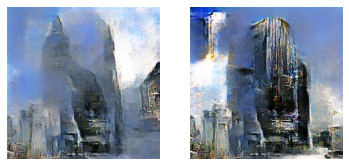

In [ ]:
X_fake, _ = generate_fake_samples(n_muestras=2, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(2):
  plt.subplot(1,2,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])
plt.savefig(os.path.join(path,"Fake_5"))

<Figure size 432x288 with 0 Axes>